
## Введение
Больше контекста про продукт - https://github.com/Hyper-glitch/artifex-ai

Данную задачу можно решить несколькими способами, но мы начнем с простого варианта и будем усложнять по мере необходимости.

Для начала будем использовать RAG подход для улучшения промпта юзера, основываясь на фирменом бренд-буке компании и дальнейшей генерации с помощью `Stable Diffusers`.
В дальнейшем, если потребуется, будем дообучать `LoRA adapter` на описаниях изображений брендбука.


## 1. Загрузка и очистка данных
Необходимо преобразовать бренд-бук из PDF в текст.
Извлеченный текст будем использовать для создания `FAISS` индекса и использования его в `RAG` пайплайне.

In [3]:
!pip install PyMuPDF
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 40.2 MB/s eta 0:00:0000:0100:01


### Комментарий (!)
В ходе использования библиотеки `fitz` для парсинга `pdf-to-text` выяснилось, что `pdf` содержит сканы изображений и он не способен распарсить его в текст, `page.get_text()` возвращает пустой текст.

В связи с этим принято решение использовать базовый `OCR` в виде библиотеки `pytesseract`. 

In [4]:
"""Извлечение данных из PDF"""

import fitz
from pathlib import Path

def extract_text_from_pdf(pdf_path: Path) -> str:
    document = fitz.open(pdf_path)
    text = ""

    for page_num in range(len(document)):
        page = document.load_page(page_num)        
        parsed_text = page.get_text()
        print(f"parsed_text: {parsed_text}")

        text += parsed_text

    return text

In [3]:
# Запуск и проверка что текст пустой

pdf_path = Path("/kaggle/input/guideline/guidelines.pdf")
text = extract_text_from_pdf(pdf_path)

parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed_text: 
parsed

In [5]:
!pip install pytesseract

In [6]:
"""Функция для извлечение данных из PDF с помощью OCR."""

from PIL import Image
import pytesseract


def extract_text_with_ocr(page):
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return pytesseract.image_to_string(img)

In [9]:
"""Извлечение данных из PDF с помощью OCR"""

import fitz
from pathlib import Path


def pdf_to_text_with_ocr(pdf_path: Path) -> str:
    document = fitz.open(pdf_path)
    text = ""

    for page_num in range(len(document)):
        page = document.load_page(page_num)        
        parsed_text = extract_text_with_ocr(page)

        text += parsed_text

    print("All pages processed successfully.")
    return text

In [8]:
# Запуск и проверка с OCR

pdf_path = Path("/kaggle/input/guideline/guidelines.pdf")
text = pdf_to_text_with_ocr(pdf_path)

### Комментарий (!)
Из полученного текста видно, что он не представляет для нас никакой ценности, так как `pytesseract` по умолчанию работает с английским языком. Установим плагин `tesseract-ocr-rus` для русского языка.

In [10]:
!apt install tesseract-ocr-rus

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tesseract-ocr-rus
0 upgraded, 1 newly installed, 0 to remove and 122 not upgraded.
Need to get 1,271 kB of archives.
After this operation, 3,877 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-rus all 1:4.00~git30-7274cfa-1.1 [1,271 kB]
Fetched 1,271 kB in 1s (1,066 kB/s)          

78Selecting previously unselected package tesseract-ocr-rus.
(Reading database ... 128691 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-rus_1%3a4.00~git30-7274cfa-1.1_all.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking tesseract-ocr-rus (1:4.00~git30-7274cfa-1.1) ...
7Progress: [ 40%] [#######################....................

In [11]:
"""Функция для извлечение данных из PDF с помощью OCR, ru+eng языки."""

from PIL import Image
import pytesseract


def extract_text_with_ocr(page):
    pix = page.get_pixmap()
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return pytesseract.image_to_string(img, lang='rus+eng')

In [13]:
# Запуск и проверка с OCR, ru+eng языки

pdf_path = Path("/kaggle/input/guideline/guidelines.pdf")
text = pdf_to_text_with_ocr(pdf_path)

All pages processed successfully.


In [12]:
"""Module for text preprocessing and segmentation"""

import re
from nltk.tokenize import sent_tokenize


def clean_text(text: str) -> str:
    """Removing extra spaces, invisible characters and duplicate lines."""
    text = text.replace("\xa0", " ").replace("\t", " ")
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'[ ]{2,}', ' ', text) 
    
    return text.strip()


def split_into_chunks(text: str, max_sentences: int = 5) -> list[str]:
    """Breaks text into chunks of N sentences for more meaningful passages."""
    sentences = sent_tokenize(text)
    chunks = []

    for i in range(0, len(sentences), max_sentences):
        chunk = " ".join(sentences[i:i + max_sentences])
        if len(chunk) > 30:
            chunks.append(chunk.strip())

    return chunks


def process_brandbook_text(full_text: str) -> list[dict[str, str]]:
    clean = clean_text(full_text)
    chunks = split_into_chunks(clean)
    return [{"content": chunk} for chunk in chunks]


In [12]:
# Векторизация текста
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [14]:
from sentence_transformers import SentenceTransformer
import numpy as np


def vectorize_chunks(embed_model: SentenceTransformer, chunks: list[dict]) -> list[dict]:
    """
    Принимает список чанков вида [{"content": str}], возвращает список с эмбеддингами
    """
    texts = [chunk["content"] for chunk in chunks]
    embeddings = embed_model.encode(texts, convert_to_numpy=True, show_progress_bar=True)

    for chunk, emb in zip(chunks, embeddings):
        chunk["embedding"] = emb

    return chunks

In [4]:
# Установка FAISS индекса
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 63.1 MB/s eta 0:00:00:00:0100:01


In [17]:
"""Create FAISS index."""

import faiss
import numpy as np
import torch


def build_faiss_index(embeddings: list[np.ndarray]) -> faiss.Index:
    dim = embeddings[0].shape[0]
    index_flat = faiss.IndexFlatL2(dim)

    faiss_vectors = np.stack(embeddings).astype(np.float32)
    index_flat.add(faiss_vectors)

    return index_flat

In [16]:
def search_similar(guideline_content: list[str], user_prompt: str, embed_model: SentenceTransformer, faiss_index: faiss.Index, top_k=3) -> list[str]:
    embedding = embed_model.encode([user_prompt]).astype("float32")
    distances, indices = faiss_index.search(embedding, top_k)
    relevant_guidelines = [guideline_content[i] for i in indices[0]]

    return relevant_guidelines

In [14]:
"""Загрузка модели на девайс."""

from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

embed_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)

cuda


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
"""Получение эмбеддингов."""

chunks = process_brandbook_text(text)
vectorized_chunks = vectorize_chunks(embed_model, chunks)
embeddings = [chunk["embedding"] for chunk in vectorized_chunks]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
"""Сохранение чанков описания гайдлайна для RAG"""
import json


guideline_content = [chunk["content"] for chunk in vectorized_chunks]

with open("guideline_content.json", "w", encoding="utf-8") as file:
    json.dump(guideline_content, file, ensure_ascii=False, indent=2)


In [33]:
"""Создание и сохранение FAISS индекса."""

faiss_index = build_faiss_index(embeddings)
faiss.write_index(faiss_index, "guideline.index")

In [39]:
user_prompt = "Хочу абстрактоного человека с абстракциями в светлых тонах"

relevant_guidelines = search_similar(guideline_content=guideline_content, user_prompt=user_prompt, embed_model=embed_model, faiss_index=faiss_index)
print(relevant_guidelines)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

['Мопо + геометричесние формы с фотононтентом\nНАЗВАНИЕМПРЕЗЕНТАЦИИ\nВМНЕСНОЛЬНОМСТРОН\nОНО ИЕСНОЛЬНО СТРОКИ erom.tech\nНАЗВАНИЕ\nПРЕЗЕНТАЦИИ\nВ_ НЕСНОЛЬНО\nСТРОН\n \nин екнилИЯ СПИКЕРА,\nГЛОЛИНОСТЬ В НЕСКОЛЬКО СТРОКУ erom.tech\n \n\x0c[10] Презентация / Разделители Для нумерации раздела используем начертание Мопо\nс внлюченным стилистичесним сетом 1. НАЗВАНИЕ РАЗДЕЛА\nВ НЕСНОЛЬНО СТРОН\n \nНАЗВАНИЕМРАЗДЕЛА\nВМНЕСНОЛЬНОЙСТРОН\n \n(01/-—\nerom.tech\n(01)\nerom.tech\n\x0c(10)\nПрезентация / Списни\nместо для\nema\nА\nХаспиши Главную мы\n \nДля нумерации блонов содержания чспользуем тоже начертание, что\nи в разделителе, для подтем и основного тенста вводим белый, для лучшего\nсчитывания нонтента. Для создания буллитов используем любую бунву moro\nже размера, что и тенст в списне, в начертании В1оснз. СОДЕРЖАНИЕ\n(01) НАЗВАНИЕ ТЕМЫ БЛОНА\n \n \n \n \n(02) НАЗВАНИЕ ТЕМЫ БЛОНА\n(03) НАЗВАНИЕ ТЕМЫ БЛОНА\nerom.tech\nЗАГОЛОВОН СЛАЙДА\nШ Ато место для основного токста — А это место для основног

### Вывод
Таким образом нам удалось перевести `pdf` файл на русском и английском языках в векторы и создать по ним `FAISS` индекс для использования в нашем `RAG` пайплайне.

## 2. Анализ данных
В `.pdf` гайдлайне также присутствуют изображения (шаблоны абстракций, цветовые сочетания и тд). Для того чтобы перевести их в машиночитаемый вид воспользуемся `image-to-text` моделями. Датасет изображений был сформирован вручную, так как в `.pdf` файле на изображениях (абстракции, цветовые сочетания) было сразу размещено до 30 разных небольших изображений и средствами автоматизации такое не сделать.

Полученные описания можно векторизовать и обогощать `system_prompt` - таким образом описание для генерации станет подробнее, что повлияет на качество конечного изображения.

Также данные описания могут пригодится нам в дальнейшем для дообучения `LoRA adapter` для `Stable Diffusers`. 

#### `Salesforce/blip2-opt-2.7b` - одна из самых простых и легковесных моделей для описания изображений, не работает с промптом для описания изображений.

In [1]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [45]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration


simple_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
simple_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16,
    device_map=device,
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [2]:
import pandas as pd
from PIL import Image
from tqdm import tqdm
from pathlib import Path


def read_prompt(prompt_path: Path) -> str:
    with open(prompt_path, "r", encoding="utf-8") as f:
        return f.read().strip()
        

def get_img_captions(dataset_path: Path, processor, model, device: torch.device, use_prompt: bool = False) -> pd.DataFrame:
    img_captions = []

    for folder in tqdm(sorted(dataset_path.iterdir()), desc="Processing folders"):
        prompt_path = folder / "prompt.txt"
        if not prompt_path.exists():
            print(f"[!] Пропускаю {folder}, нет prompt.txt")
            continue

        if use_prompt:
            prompt = read_prompt(prompt_path)
        else:
            prompt = ""

        for image_path in folder.iterdir():
            if image_path.suffix.lower() not in (".png", ".jpg", ".jpeg", ".webp"):
                continue

            try:
                image = Image.open(image_path).convert("RGB")
                inputs = processor(images=image, text=prompt, return_tensors="pt").to(device)

                with torch.no_grad():
                    generated_ids = model.generate(**inputs, do_sample=False, num_beams=5, max_length=256, min_length=1, top_p=0.9, repetition_penalty=1.5, length_penalty=1.0, temperature=1)

                caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                
                img_captions.append({
                    "folder": folder.name,
                    "image_name": image_path.name,
                    "prompt": prompt,
                    "caption": caption,
                })
            except Exception as e:
                print(f"[X] Ошибка с {image_path}: {e}")

    return img_captions

In [3]:
def save_captions(img_captions: list[dict], model) -> None:
    df = pd.DataFrame(img_captions)
    df.to_csv(f"{model.__class__.__name__.lower()}_img_captions.csv", index=False, encoding="utf-8")
    print(f"✅ Сохранено {len(df)} описаний в img_captions.csv")

In [50]:
DATASET = Path("/kaggle/input/images/imgs")
img_captions = get_img_captions(dataset_path=DATASET, model=simple_model, processor=simple_processor, device=device)
save_captions(img_captions, simple_model)

Processing folders:  50%|█████     | 3/6 [01:04<01:06, 22.07s/it]

[!] Пропускаю /kaggle/input/images/imgs/colors.numbers, нет prompt.txt


Processing folders: 100%|██████████| 6/6 [01:22<00:00, 13.80s/it]

[!] Пропускаю /kaggle/input/images/imgs/simple, нет prompt.txt
✅ Сохранено 190 описаний в img_captions.csv


#### `Salesforce/instructblip-flan-t5-xl` - более продвинутая и ресурсоемкая модель для описания изображений, с промптом работает, выдает более сложное и подробное описание изображения. На данном этапе выбор модели метриками не подкреплялась.

In [4]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration


processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
model = InstructBlipForConditionalGeneration.from_pretrained(
    "Salesforce/instructblip-flan-t5-xl",
    torch_dtype=torch.float16,
).to(device)

2025-05-07 18:01:42.836287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746640903.028103      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746640903.085549      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/75.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.31k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/135k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/6.11G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [5]:
DATASET = Path("/kaggle/input/images/imgs")
img_captions = get_img_captions(dataset_path=DATASET, model=model, processor=processor, device=device, use_prompt=True)
save_captions(img_captions)

Processing folders:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Processing folders:  17%|█▋        | 1/6 [04:52<24:20, 292.01s/it]


KeyboardInterrupt: 

#### Создадим FAISS индекс для полученных описаний с изображений.

In [ ]:
import pandas as pd
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import pickle


df = pd.read_csv(f"{model.__class__.__name__}_img_captions.csv")

embed_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2", device=device)
embeddings = embed_model.encode(df["caption"].tolist(), show_progress_bar=True)

faiss_index = build_faiss_index(embeddings)
faiss.write_index(faiss_index, f"{model.__class__.__name__.lower()}_img_captions.index")
print(f"✅ Готово! В индекс добавлено {len(embeddings)} описаний.")


#### Найдем ближайшие `top_k` описаний изображений под пользовательский запрос

In [ ]:
query = "abstract man which walking"
top_k = 3

embedding = embed_model.encode([query]).astype("float32")
distances, indices = faiss_index.search(embedding, top_k)

for idx in indices[0]:
    row = df.iloc[idx]
    print(f"[{idx}] {row['caption']}")

## 3. Выбор 1-2 простых модели и 1 усложнённой

В качестве простых моделей возьмем `Stable Diffusion 1.5` и `Stable Diffusion 2.1-base`. В качестве усложненной - `Kandinsky 2.2`

In [1]:
pip install diffusers transformers accelerate xformers

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 59.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 110.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [1]:
pip install transformers diffusers

Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device.type)

cuda


In [3]:
# Загружаем индексы и описания с бренд-бука

import faiss
import json
import pandas as pd


blip_pro_index = faiss.read_index("/kaggle/input/blip-pro/instructblipforconditionalgeneration_img_captions.index")
blip_pro_df = pd.read_csv("/kaggle/input/blip-pro/InstructBlipForConditionalGeneration_img_captions.csv")

guideline_index = faiss.read_index("/kaggle/input/guideline-index/guideline.index")
with open("/kaggle/input/guideline-index/guideline_content.json", "r", encoding="utf-8") as file:
    guideline_content = json.load(file)

ModuleNotFoundError: No module named 'faiss'

#### Подготавливаем промпт для `Stable Diffusion`

In [33]:
user_prompt = "Нужен контент с абстрактным человеком и разными деталями в ярких цветах."

In [34]:
relevant_guidelines = search_similar(guideline_content=guideline_content, user_prompt=user_prompt, embed_model=embed_model, faiss_index=guideline_index)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
image_captions = search_similar(guideline_content=blip_pro_df["caption"], user_prompt=user_prompt, embed_model=embed_model, faiss_index=blip_pro_index)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
guidelines_str = "\n".join(f"- {g}" for g in relevant_guidelines)
captions_str = "\n".join(f'{i+1}. "{desc}"' for i, desc in enumerate(image_captions))

system_prompt = f"""
You are an AI assistant specialized in generating brand-consistent visual content using Stable Diffusion.

Your task:
1. Transform the user's input into a detailed and well-structured prompt for image generation.
2. Follow the brand guidelines to ensure the result aligns with the company's visual identity.
3. Use the three example image descriptions as inspiration for the tone, style, and atmosphere of the generated image.

User input:
"{user_prompt}"

Relevant brand guidelines:
{guidelines_str}

Example image descriptions:
{captions_str}

"""

In [37]:
system_prompt

'\nYou are an AI assistant specialized in generating brand-consistent visual content using Stable Diffusion.\n\nYour task:\n1. Transform the user\'s input into a detailed and well-structured prompt for image generation.\n2. Follow the brand guidelines to ensure the result aligns with the company\'s visual identity.\n3. Use the three example image descriptions as inspiration for the tone, style, and atmosphere of the generated image.\n\nUser input:\n"Нужен контент с абстрактным человеком и разными деталями в ярких цветах, их должно быть 4"\n\nRelevant brand guidelines:\n- 2. Использовать нефирменные шрифты. 3. Менять цвет на любой другой, нроме фирменных. 4.\n- Не применять дополнительные эффенты н начертанию Влоснз. 4. Не разделять один смысловой блон тенста на неснольно\nцветовых сочетаний. я\nРУНОВОДИТЕЛЬ =\n ТЛЕЛА ТОВАРОВ\nИ\nOTAENA\n \n\x0c1. Гарнитура $49па1 Мопо в начестве заголовочного шрифта.\n- Более\nпого, 30 должна отличаться по цвету от остальных 2 цветов на макете. Mono/Gr

### Пояснение (!)
Далее нам необходимо улучшить промпт с помощью `LLM`. Но так как технической возможности развернуть `LLM` в `kaggle` нет, то на этапе `baseline`
будем использовать готовый промпт от `ChatGPT`.

На финальной же защите проекта у итогового сервиса будет доступ до `HGX` кластера с развернутой нами `LLM (llama-3.3-70b)` в `Triton Inference Server`.

In [29]:
# Полученный от ChatGPT промпт, основанный на релевантных top_k чанков гайдлайна и image captions.

improved_prompt_gpt = """
An abstract 2D illustration featuring a human figure with four distinct, vibrant details in bold colors. The figure is minimalistic yet dynamic, composed of geometric shapes and clean lines, using a color palette of four contrasting tones. No 3D elements or photographic textures. The design follows the brand's visual identity, with no additional effects applied to the VlosaNz typeface or text. The illustration avoids combining multiple color schemes within the same semantic block. The background is simple and enhances the focus on the abstract human figure.
"""

#### Генерация изображения с помощью Stable Diffusion 1.5

In [2]:
def generate_image_with_diffusers(prompt: str, steps=25):
    output = pipe(prompt=prompt, num_inference_steps=steps)
    
    return output.images[0]

In [5]:
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (106 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. the illustration avoids combining multiple color schemes within the same semantic block . the background is simple and enhances the focus on the abstract human figure .']


  0%|          | 0/100 [00:00<?, ?it/s]

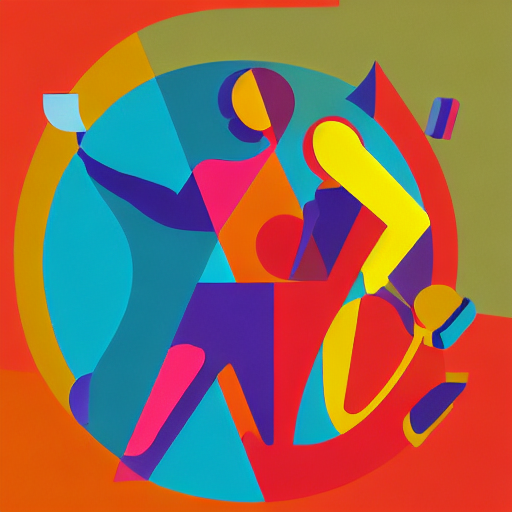

In [8]:
from IPython.display import display


image = generate_image_with_diffusers(improved_prompt_gpt, steps=100)
image.save("generated_stable-diffusion-v1-5.png")

display(image)

#### Генерация изображения с помощью stable-diffusion-2-1-base

In [9]:
import torch
from diffusers import StableDiffusionPipeline


pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base").to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (106 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. the illustration avoids combining multiple color schemes within the same semantic block . the background is simple and enhances the focus on the abstract human figure .']


  0%|          | 0/100 [00:00<?, ?it/s]

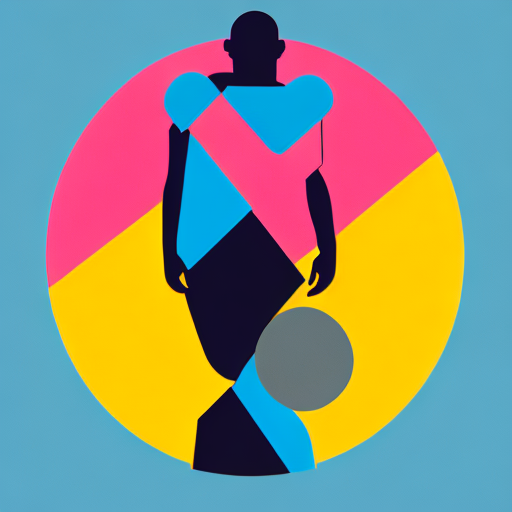

In [10]:
from IPython.display import display


image = generate_image_with_diffusers(improved_prompt_gpt, steps=100)
image.save("generated_stable-diffusion-2-1-base.png")

display(image)

#### Генерация изображения с помощью Kandinsky 2.2

In [8]:
pip install diffusers transformers accelerate

Note: you may need to restart the kernel to use updated packages.


In [11]:
from diffusers import AutoPipelineForText2Image


pipe = AutoPipelineForText2Image.from_pretrained("kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16)
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.01G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.02k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/315 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.10G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (106 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. the illustration avoids combining multiple color schemes within the same semantic block . the background is simple and enhances the focus on the abstract human figure .']


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/kandinsky2_2/pipeline_kandinsky2_2.py:202: FutureWarning: `callback_steps` is deprecated and will be removed in version 1.0.0. Passing `callback_steps` as an input argument to `__call__` is deprecated, consider use `callback_on_step_end`
  deprecate(


  0%|          | 0/10 [00:00<?, ?it/s]

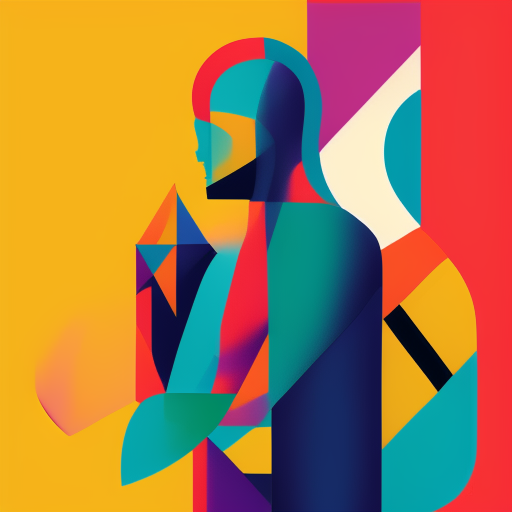

In [12]:
from IPython.display import display


image = generate_image_with_diffusers(improved_prompt_gpt, steps=10)
image.save("generated_kandinsky-2-2-decoder.png")

display(image)

## 4. Оценка метрик качества

#### 4.1 Image-Text Matching (ITM)

Здесь мы оцениваем соответствие сгенерированных изображений исходному текстовому описанию с помощью метрики Image-Text Matching, основанной на модели BLIP. Она возвращает вероятность в диапазоне от 0 до 1, отражающую степень семантического соответствия изображения и текста.

In [43]:
from transformers import BlipProcessor, BlipModel


processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
model = BlipModel.from_pretrained("Salesforce/blip-itm-base-coco").to(device)

`BlipModel` is going to be deprecated in future release, please use `BlipForConditionalGeneration`, `BlipForQuestionAnswering` or `BlipForImageTextRetrieval` depending on your usecase.
Some weights of BlipModel were not initialized from the model checkpoint at Salesforce/blip-itm-base-coco and are newly initialized: ['logit_scale', 'text_model.embeddings.LayerNorm.bias', 'text_model.embeddings.LayerNorm.weight', 'text_model.embeddings.position_embeddings.weight', 'text_model.embeddings.word_embeddings.weight', 'text_model.encoder.layer.0.attention.output.LayerNorm.bias', 'text_model.encoder.layer.0.attention.output.LayerNorm.weight', 'text_model.encoder.layer.0.attention.output.dense.bias', 'text_model.encoder.layer.0.attention.output.dense.weight', 'text_model.encoder.layer.0.attention.self.key.bias', 'text_model.encoder.layer.0.attention.self.key.weight', 'text_model.encoder.layer.0.attention.self.query.bias', 'text_model.encoder.layer.0.attention.self.query.weight', 'text_model.enco

In [61]:
def blip_similarity(image_path: str, text_prompt: str) -> float:
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits_per_image
    return torch.sigmoid(logits)[0][0].item()

In [54]:
diffusion_1_5_blip_score = blip_similarity("/kaggle/input/gen-output/generated_stable-diffusion-v1-5.png", improved_prompt_gpt)

In [56]:
diffusion_2_1_blip_score = blip_similarity("/kaggle/input/gen-output/generated_stable-diffusion-2-1-base.png", improved_prompt_gpt)

In [59]:
kandinsky_blip_score = blip_similarity("/kaggle/input/gen-output/generated_kandinsky-2-2-decoder.png", improved_prompt_gpt)

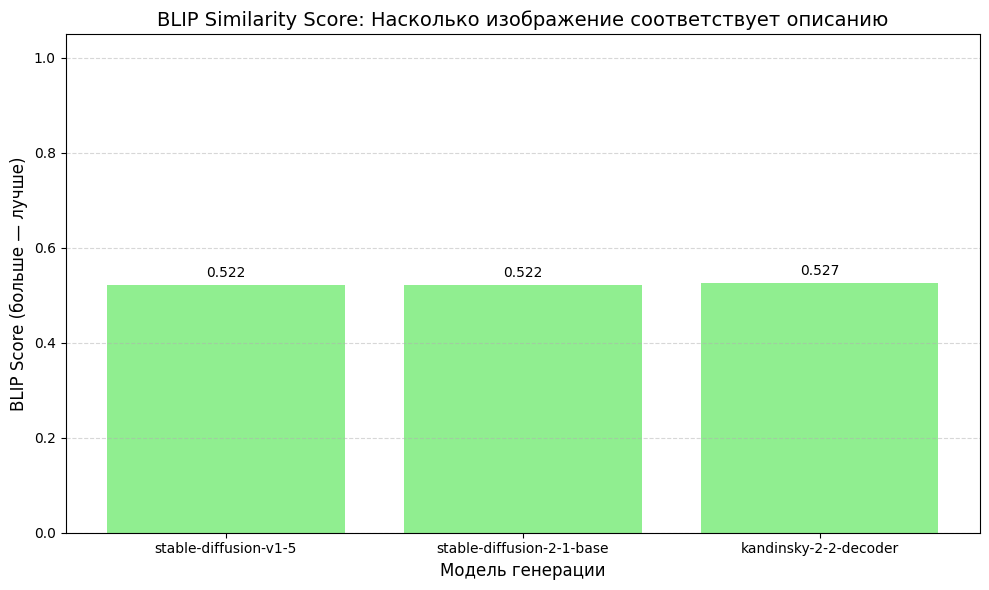

In [80]:
import matplotlib.pyplot as plt


blip_scores = {
    "stable-diffusion-v1-5": diffusion_1_5_blip_score,
    "stable-diffusion-2-1-base": diffusion_2_1_blip_score,
    "kandinsky-2-2-decoder": kandinsky_blip_score
}

plt.figure(figsize=(10, 6))
bars = plt.bar(blip_scores.keys(), blip_scores.values(), color='lightgreen')
plt.title("BLIP Similarity Score: Насколько изображение соответствует описанию", fontsize=14)
plt.xlabel("Модель генерации", fontsize=12)
plt.ylabel("BLIP Score (больше — лучше)", fontsize=12)
plt.ylim(0, 1.05)

for bar, score in zip(bars, blip_scores.values()):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{score:.3f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### 4.2 LPIPS: Сходство со стилевыми паттернами

LPIPS (Learned Perceptual Image Patch Similarity) — это метрика, специально разработанная для оценки перцептуального сходства изображений. В отличие от традиционных метрик, таких как PSNR или SSIM, LPIPS ориентирована на сходство восприятия человеком, а не на числовое совпадение пикселей. LPIPS оценивает схожесть не на уровне простых пиксельных разностей, а с учётом перцептуальных особенностей изображений, таких как формы, текстуры и другие стилистические особенности.

In [3]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [15]:
import lpips
import torch
from torchvision import transforms


device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = lpips.LPIPS(net='vgg').to(device)
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Нормализация для LPIPS
])

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/vgg.pth


In [16]:
def preprocess_image(image_path: str, preprocess):
    image = Image.open(image_path).convert('RGB')
    return preprocess(image).unsqueeze(0).to(device)

In [12]:
def compute_average_lpips(generated_image_path, original_image_paths):
    total_lpips = 0

    for orig_image_path in original_image_paths:
        processed_original_image = preprocess_image(orig_image_path, preprocess)
        processed_generated_image = preprocess_image(generated_image_path, preprocess)
        lpips_score = loss_fn(processed_generated_image, processed_original_image).item()
        total_lpips += lpips_score
    
    return total_lpips / len(original_image_paths)

In [21]:
from pathlib import Path


original_image_paths = list(path for path in Path("/kaggle/input/images/imgs/compositions").iterdir() if str(path).split(".")[-1] != "txt")
generated_image_paths = list(Path("/kaggle/input/gen-output").iterdir())

In [22]:
# Вычисление LPIPS для каждого сгенерированного изображения
from PIL import Image


average_lpips_scores = {}

for gen_image_path in generated_image_paths:
    average_lpips_scores[gen_image_path] = compute_average_lpips(gen_image_path, original_image_paths)

for gen_image, score in average_lpips_scores.items():
    print(f"Среднее LPIPS для {gen_image}: {score}")

Среднее LPIPS для /kaggle/input/gen-output/generated_stable-diffusion-2-1-base.png: 0.8790033814069387
Среднее LPIPS для /kaggle/input/gen-output/generated_kandinsky-2-2-decoder.png: 0.929375983573295
Среднее LPIPS для /kaggle/input/gen-output/generated_stable-diffusion-v1-5.png: 0.9249271573247136


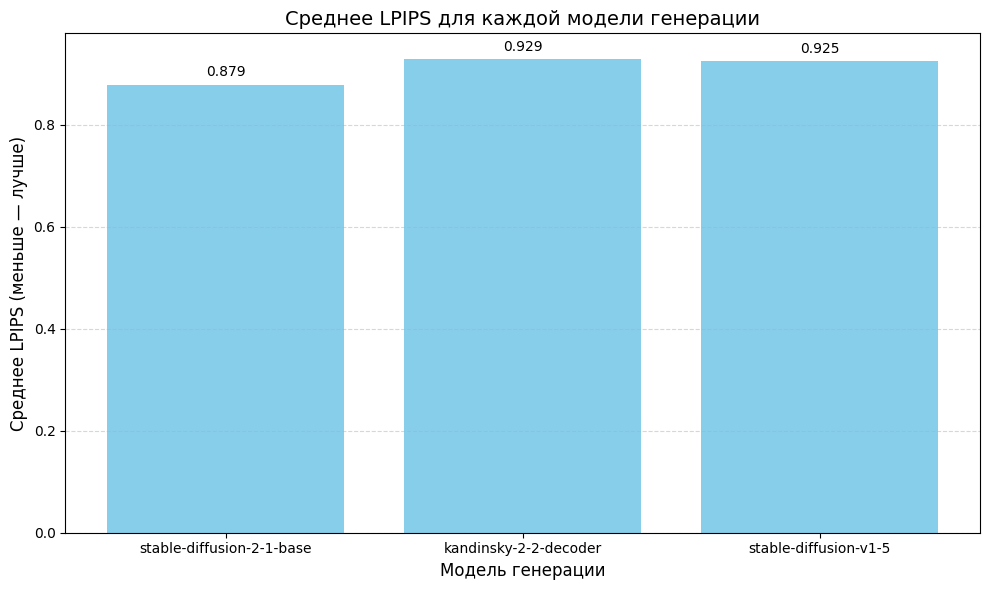

In [81]:
import matplotlib.pyplot as plt


model_names = [p.name.replace("generated_", "").replace(".png", "") for p in average_lpips_scores.keys()]
scores = list(average_lpips_scores.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, scores, color='skyblue')
plt.title("Среднее LPIPS для каждой модели генерации", fontsize=14)
plt.xlabel("Модель генерации", fontsize=12)
plt.ylabel("Среднее LPIPS (меньше — лучше)", fontsize=12)
plt.ylim(0, max(scores) + 0.05)

for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{score:.3f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### 4.3 Совмещаем метрики в одну общую

In [92]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np


model_metrics = {
    name: {
        "lpips": average_lpips_scores[path],
        "blip": list(blip_scores.values())[i]
    }
    for i, (name, path) in enumerate(zip(model_names, average_lpips_scores.keys()))
}

lpips_raw = {model: metrics["lpips"] for model, metrics in model_metrics.items()}
blip_raw = {model: metrics["blip"] for model, metrics in model_metrics.items()}

# Нормализуем LPIPS — чем меньше, тем лучше, поэтому инвертируем
lpips_values = np.array(list(lpips_raw.values())).reshape(-1, 1)
lpips_scaler = MinMaxScaler()
lpips_norm_values = 1 - lpips_scaler.fit_transform(lpips_values).flatten()  # инвертируем, чтобы "лучше" = больше

combined_scores = {
    model: 0.3 * blip_raw[model] + 0.7 * lpips_norm
    for model, lpips_norm in zip(lpips_raw.keys(), lpips_norm_values)
}

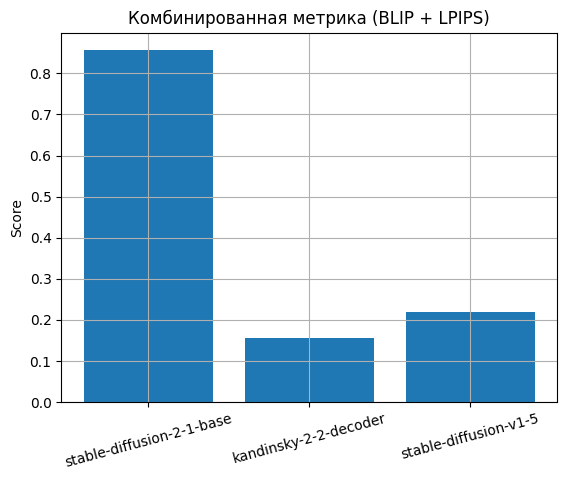

In [91]:
import matplotlib.pyplot as plt


models = list(combined_scores.keys())
values = [combined_scores[m] for m in models]

plt.bar(models, values)
plt.title("Комбинированная метрика (BLIP + LPIPS)")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(True)
plt.show()

## Вывод
Исходя из значений `combined_scores`, выбор модели для генерации корпоративного контента будет следующим:

Выбираем модель `stable-diffusion-2-1-base`, так как она имеет наивысший комбинированный балл `0.857`. Это означает, что эта модель показывает лучшее качество по обеим метрикам `(BLIP и LPIPS)` среди всех рассматриваемых моделей.